In [1]:
import numpy as np
import random
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
from qiskit.quantum_info import DensityMatrix, random_density_matrix
from qiskit.quantum_info.operators import Operator
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.linalg import sqrtm
from scipy.optimize import minimize

import torch
#tensorflow imports
from tensorflow import keras
from keras import layers, losses, Model
import logging
tf.get_logger().setLevel(logging.ERROR)

python Data_build_final.py --n_qubits 2 --n_states 100000 --shots_per_basis 100_000 --pure_fraction 0.5 --noise --xi 0.20 --noise_mode basis --output 2q_noise_0.20.npz

In [27]:
data_01 = np.load('../datasets/2_qubit_noisy/2q_noise_0.01.npz')
data_02 = np.load('../datasets/2_qubit_noisy/2q_noise_0.02.npz')
data_05 = np.load('../datasets/2_qubit_noisy/2q_noise_0.05.npz')
data_10 = np.load('../datasets/2_qubit_noisy/2q_noise_0.1.npz')
data_15 = np.load('../datasets/2_qubit_noisy/2q_noise_0.15.npz')
data_20 = np.load('../datasets/2_qubit_noisy/2q_noise_0.2.npz')

X_01 = data_01['counts'] / data_01['shots_per_basis']; y_01 = data_01['states']
X_02 = data_02['counts'] / data_02['shots_per_basis']; y_02 = data_02['states']
X_05 = data_05['counts'] / data_05['shots_per_basis']; y_05 = data_05['states']
X_10 = data_10['counts'] / data_10['shots_per_basis']; y_10 = data_10['states']
X_15 = data_15['counts'] / data_15['shots_per_basis']; y_15 = data_15['states']
X_20 = data_20['counts'] / data_20['shots_per_basis']; y_20 = data_20['states']
rng = np.random.default_rng(42)
test_ind_pure = rng.choice(50_000, size=1000, replace=False)
test_ind_mixed = rng.integers(50_000, 100_000, size=1000)

In [3]:
# compute Fidelity
def fidelity(rho1, rho2):
    sqrt_rho1 = sqrtm(rho1)
    F = np.trace(sqrtm(sqrt_rho1 @ rho2 @ sqrt_rho1))
    return np.real(F)**2

# Map the cholesky parameterised vector to a PSD trace 1 density matrix
def params_to_rho(params):
    # params: length 16
    L = np.zeros((4,4), dtype=complex)
    idx = 0
    # diagonal entries (real, positive)
    for i in range(4):
        L[i, i] = params[idx]
        idx += 1
    # lower-triangular off-diagonals (real + imag)
    for i in range(1, 4):
        for j in range(i):
            re = params[idx]; im = params[idx+1]
            L[i, j] = re + 1j * im
            idx += 2
    rho = L @ L.conj().T
    return rho / np.trace(rho)


def build_single_qubit_Us():
    X_cols = [np.array([1, 1])/np.sqrt(2),
              np.array([1,-1])/np.sqrt(2)]
    Y_cols = [np.array([1, 1j])/np.sqrt(2),
              np.array([1,-1j])/np.sqrt(2)] 
    Z_cols = [np.array([1,0]), np.array([0,1])]
    return {'X': np.column_stack(X_cols),
            'Y': np.column_stack(Y_cols),
            'Z': np.column_stack(Z_cols)}

def build_povm():
    proj = []
    for m in range(4):
        P = np.zeros((4,4), dtype=complex)
        P[m, m] = 1.0
        proj.append(P)

    Us = build_single_qubit_Us()
    settings = []
    for b1 in ['X','Y','Z']:
        for b2 in ['X','Y','Z']:
            settings.append(np.kron(Us[b1], Us[b2]))

    E = []
    for U in settings:
        U_dag = U.conj().T
        for P in proj:
            E.append(U @ P @ U_dag)
    return E

E_GLOBAL = build_povm()

def neg_log_likelihood(params, count):
    rho = params_to_rho(params)
    rho = 0.5*(rho + rho.conj().T)
    probs = np.array([np.trace(E @ rho).real for E in E_GLOBAL])
    probs = np.clip(probs, 0.0, None)
    s = probs.sum()
    if s <= 0: probs[:] = 1.0/len(probs)
    else: probs /= s
    return -np.sum(count * np.log(np.clip(probs, 1e-12, 1.0)))


def MLE_Avg_fidelity(data, X, y):
    shots = data['shots_per_basis']
    counts = (X * shots).astype(int)        # freq counts    

    N = X.shape[0]
    #initialise the estimator
    rho_est = np.zeros((N, 4, 4), dtype=complex)

    for i in range(N):
    
        # initial guess: uniform identity
        init = np.zeros(16)
        init[:4] = np.sqrt(1/4)
    
        res = minimize(
            neg_log_likelihood, init, args=(counts[i],),
            method='L-BFGS-B',
            options={'maxiter': 500}
        )
        #reconstruct the density matrix from cholesky decomp
        rho_est[i] = params_to_rho(res.x)

    fidelities = np.array([fidelity(rho_est[i], y[i]) for i in range(N)])

    mean_fidelity = np.mean(fidelities)
    std_fidelity  = np.std(fidelities)
    return (mean_fidelity, std_fidelity)

In [4]:
def alpha_to_rho(alpha):
    """Convert batch of alpha vectors to density matrices using Cholesky."""
    N = alpha.shape[0]
    rho = np.zeros((N, 4, 4), dtype=np.complex64)
    for i in range(N):
        a = alpha[i]
        L = np.zeros((4, 4), dtype=np.complex64)
        idx = 0
        for j in range(4):
            L[j, j] = a[idx]
            idx += 1
        for j in range(1, 4):
            for k in range(j):
                re = a[idx]
                im = a[idx + 1]
                L[j, k] = re + 1j * im
                idx += 2
        rho_i = L @ L.conj().T
        rho[i] = rho_i / np.trace(rho_i)
    return rho

def reconstruct_true_rho(y):
    """Convert vectorized real+imag back to complex 4x4 matrices."""
    N = y.shape[0]
    real = y[:, :16].reshape(N, 4, 4)
    imag = y[:, 16:].reshape(N, 4, 4)
    return real + 1j * imag


def rho_to_alpha(rho):
    """
    Convert a (d x d) density matrix rho into its "Cholesky parameters" alpha.
    """
    L = np.linalg.cholesky(rho + 1e-14 * np.eye(rho.shape[0]))
    d = rho.shape[0]
    alpha = []
    # diagonal (real, >0)
    for i in range(d):
        alpha.append(np.real(L[i, i]))
    # strictly lower triangle (real + imag)
    for i in range(1, d):
        for j in range(i):
            alpha.append(np.real(L[i, j]))
            alpha.append(np.imag(L[i, j]))
    return np.array(alpha, dtype=np.float32)

def fidelity(rho1, rho2):
    A = sqrtm(rho1)
    return np.real(np.trace(sqrtm(A @ rho2 @ A)))**2


def tf_sqrtm_psd(A):
    """
    Compute principal sqrt of Hermitian PSD A (batch,d,d) via eigendecomposition.
    """
    
    eigvals, eigvecs = tf.linalg.eigh(A)

    eigvals = tf.math.real(eigvals)
    eigvals = tf.clip_by_value(eigvals, 0.0, tf.reduce_max(eigvals))
    sqrtvals = tf.sqrt(eigvals)
    D = tf.cast(tf.linalg.diag(sqrtvals), tf.complex64)
    
    return eigvecs @ D @ tf.linalg.adjoint(eigvecs)

def tf_alpha_to_rho(alpha, d):
    """
    Map real alpha (batch, N_alpha) -> complex density matrices (batch, d, d).
    Enforces positivity via a softplus on the Cholesky diag.
    """
    batch = tf.shape(alpha)[0]
    # split diag vs off-diag
    raw_diag = alpha[:, :d] 
    off_vals  = alpha[:, d:] 

    # start zero L
    L = tf.zeros((batch, d, d), tf.complex64)

    diag_pos = tf.nn.softplus(raw_diag) + 1e-6 
    diag_c   = tf.cast(diag_pos, tf.complex64)
    L = tf.linalg.set_diag(L, diag_c)

    idx = 0
    for i in range(1, d):
        for j in range(i):
            re = off_vals[:, idx]
            im = off_vals[:, idx+1]
            idx += 2
            cij = (tf.cast(re, tf.complex64)
                   + 1j * tf.cast(im, tf.complex64))
            cij = tf.reshape(cij, (batch, 1, 1))

            # mask with a one-hot at (i,j)
            flat = tf.one_hot(i*d + j, d*d, dtype=tf.complex64)
            mask = tf.reshape(flat, (d, d))[None, :, :]

            L = L + cij * mask

    rho = L @ tf.linalg.adjoint(L)  
    tr  = tf.linalg.trace(rho)
    return rho / tr[:, None, None]

def make_fidelity_loss(d):
    def fidelity_loss(alpha_true, alpha_pred):
        rho_t = tf_alpha_to_rho(alpha_true, d)
        rho_p = tf_alpha_to_rho(alpha_pred, d)

        # tiny regularizer to guard numeric issues
        I = tf.eye(d, dtype=tf.complex64)[None, :, :]
        rho_t = rho_t + 1e-8 * I
        rho_p = rho_p + 1e-8 * I

        sqrt_t = tf_sqrtm_psd(rho_t)
        inter  = sqrt_t @ (rho_p @ sqrt_t)
        s_mat  = tf_sqrtm_psd(inter)

        tr_s = tf.linalg.trace(s_mat)
        F = tf.abs(tr_s)**2
        return tf.reduce_mean(1.0 - F)
    return fidelity_loss

def make_hybrid_loss(d, lam=0.8):
    """
    Hybrid loss = lam * MSE + (1 - lam) * (1 - fidelity).
    """
    fid_loss_fn = make_fidelity_loss(d)

    def hybrid_loss(alpha_true, alpha_pred):
        # MSE on the Cholesky parameters
        mse = tf.reduce_mean(tf.square(alpha_true - alpha_pred))

        # fidelity loss already = mean(1 - F)
        phys = fid_loss_fn(alpha_true, alpha_pred)

        return lam * mse + (1.0 - lam) * phys

    return hybrid_loss

def alpha_to_rho_batch(d, alpha):
    """Convert batch of alpha vectors to density matrices using Cholesky."""
    N = alpha.shape[0]
    rho = np.zeros((N, d, d), dtype=np.complex64)
    for i in range(N):
        a = alpha[i]
        L = np.zeros((d, d), dtype=np.complex64)
        idx = 0
        for j in range(d):
            L[j, j] = a[idx]
            idx += 1
        for j in range(1, d):
            for k in range(j):
                re = a[idx]
                im = a[idx + 1]
                L[j, k] = re + 1j * im
                idx += 2
        rho_i = L @ L.conj().T
        rho[i] = rho_i / np.trace(rho_i)
    return rho

def train_NN_fidelity(X, y, idx, lam=0.8, epochs=20):
    
    X_test = X[idx]; y_test = y[idx]
    X_train = np.delete(X, idx, axis=0)
    y_train = np.delete(y, idx, axis=0)

    alphas = np.stack([rho_to_alpha(y[i]) for i in range(len(y))], axis=0)
    d = y_train.shape[1]

    alphas_train = np.stack([rho_to_alpha(rho) for rho in y_train], axis=0)
    N_alpha = alphas_train.shape[1]

    model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(N_alpha),
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=make_hybrid_loss(d, lam=lam),
    )

    # fit
    history = model.fit(
        X_train, alphas_train,
        validation_split=0.1,
        epochs=epochs,
        batch_size=64,
    )

    alpha_pred = model.predict(X_test)      
    rho_pred = alpha_to_rho_batch(d, alpha_pred)  

    # Compute fidelities
    fidelities = np.array([
        fidelity(rho_pred[i], y_test[i])
        for i in range(len(rho_pred))
    ])

    # Summary
    mean_fid = np.mean(fidelities)
    std_fid = np.std(fidelities)
    return(mean_fid, std_fid)

# State Level Noise

## Pure states

In [12]:
MLE_fid_01_state, MLE_std_01_state = MLE_Avg_fidelity(data_01, X_01[test_ind_pure], y_01[test_ind_pure])
MLE_fid_02_state, MLE_std_02_state = MLE_Avg_fidelity(data_02, X_02[test_ind_pure], y_02[test_ind_pure])
MLE_fid_05_state, MLE_std_05_state = MLE_Avg_fidelity(data_05, X_05[test_ind_pure], y_05[test_ind_pure])
MLE_fid_10_state, MLE_std_10_state = MLE_Avg_fidelity(data_10, X_10[test_ind_pure], y_10[test_ind_pure])
MLE_fid_15_state, MLE_std_15_state = MLE_Avg_fidelity(data_15, X_15[test_ind_pure], y_15[test_ind_pure])
MLE_fid_20_state, MLE_std_20_state = MLE_Avg_fidelity(data_20, X_20[test_ind_pure], y_20[test_ind_pure])

In [28]:
NN_01_fid_state, NN_std_01_state = train_NN_fidelity(X_01, y_01, test_ind_pure, epochs=40)

Epoch 1/40
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.1112 - val_loss: 0.0081
Epoch 2/40
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0132 - val_loss: 0.0074
Epoch 3/40
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0111 - val_loss: 0.0063
Epoch 4/40
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0102 - val_loss: 0.0055
Epoch 5/40
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0094 - val_loss: 0.0058
Epoch 6/40
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 7/40
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0089 - val_loss: 0.0055
Epoch 8/40
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0086 - val_loss: 0.0050
Epoch 9/40
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0083 - val_loss: 0.0055
Epoch 10/40
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0082 - val_loss: 0.0059
Epoch 11/40
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0080 - val_loss: 0.0047
Epoch 12/40
1393/1393 ━━━━━━━━

In [ ]:
NN_02_fid_state, NN_std_02_state = train_NN_fidelity(X_02, y_02, test_ind_pure)
NN_05_fid_state, NN_std_05_state = train_NN_fidelity(X_05, y_05, test_ind_pure)
NN_10_fid_state, NN_std_10_state = train_NN_fidelity(X_10, y_10, test_ind_pure)
NN_15_fid_state, NN_std_15_state = train_NN_fidelity(X_15, y_15, test_ind_pure)
NN_20_fid_state, NN_std_20_state = train_NN_fidelity(X_20, y_20, test_ind_pure)

Epoch 1/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.1151 - val_loss: 0.0082
Epoch 2/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0135 - val_loss: 0.0081
Epoch 3/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0114 - val_loss: 0.0073
Epoch 4/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0104 - val_loss: 0.0067
Epoch 5/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0099 - val_loss: 0.0054
Epoch 6/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0096 - val_loss: 0.0066
Epoch 7/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0091 - val_loss: 0.0061
Epoch 8/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0089 - val_loss: 0.0059
Epoch 9/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0087 - val_loss: 0.0055
Epoch 10/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0085 - val_loss: 0.0058
Epoch 11/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0083 - val_loss: 0.0058
Epoch 12/20
1393/1393 ━━━━━━━━

In [1]:

xi = [0.01, 0.02, 0.05, 0.1, 0.15, 0.2]
fidelities = np.array([MLE_fid_01_state, MLE_fid_02_state, MLE_fid_05_state, MLE_fid_10_state, MLE_fid_15_state, MLE_fid_20_state])
std = np.array([MLE_std_01_state, MLE_std_02_state, MLE_std_05_state, MLE_std_10_state, MLE_std_15_state, MLE_std_20_state])
#NN fidelities
fidelities_NN = np.array([NN_01_fid_state, NN_02_fid_state, NN_05_fid_state, NN_10_fid_state, NN_15_fid_state, NN_20_fid_state])
std_NN = 0.5* np.array([NN_std_01_state, NN_std_02_state, NN_std_05_state, NN_std_10_state, NN_std_15_state, NN_std_20_state])

plt.figure(figsize=(7,5))
plt.errorbar(xi, 1-fidelities, yerr=std, fmt='o-', capsize=5, label="MLE", markersize=6)
plt.errorbar(xi, 1-fidelities_NN, yerr=std_NN, fmt='o-', capsize=5, label="DNN", markersize=6)

plt.xlabel(r"Noise Level $\xi$")
plt.ylabel("Infidelity")
plt.title("Infidelity vs. Noise Level 2 Qubit Pure States")
plt.ylim(-0.025,0.2)
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.show()

NameError: name 'np' is not defined

## Mixed states

In [15]:
MLE_fid_01_mixed_state, MLE_std_01_mixed_state = MLE_Avg_fidelity(data_01, X_01[test_ind_mixed], y_01[test_ind_mixed])
MLE_fid_02_mixed_state, MLE_std_02_mixed_state = MLE_Avg_fidelity(data_02, X_02[test_ind_mixed], y_02[test_ind_mixed])
MLE_fid_05_mixed_state, MLE_std_05_mixed_state = MLE_Avg_fidelity(data_05, X_05[test_ind_mixed], y_05[test_ind_mixed])
MLE_fid_10_mixed_state, MLE_std_10_mixed_state = MLE_Avg_fidelity(data_10, X_10[test_ind_mixed], y_10[test_ind_mixed])
MLE_fid_15_mixed_state, MLE_std_15_mixed_state = MLE_Avg_fidelity(data_15, X_15[test_ind_mixed], y_15[test_ind_mixed])
MLE_fid_20_mixed_state, MLE_std_20_mixed_state = MLE_Avg_fidelity(data_20, X_20[test_ind_mixed], y_20[test_ind_mixed])

In [16]:
NN_01_fid_mixed_state, NN_std_01_mixed_state = train_NN_fidelity(X_01, y_01, test_ind_mixed)
NN_02_fid_mixed_state, NN_std_02_mixed_state = train_NN_fidelity(X_02, y_02, test_ind_mixed)
NN_05_fid_mixed_state, NN_std_05_mixed_state = train_NN_fidelity(X_05, y_05, test_ind_mixed)
NN_10_fid_mixed_state, NN_std_10_mixed_state = train_NN_fidelity(X_10, y_10, test_ind_mixed)
NN_15_fid_mixed_state, NN_std_15_mixed_state = train_NN_fidelity(X_15, y_15, test_ind_mixed)
NN_20_fid_mixed_state, NN_std_20_mixed_state = train_NN_fidelity(X_20, y_20, test_ind_mixed)

Epoch 1/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.1168 - val_loss: 0.0095
Epoch 2/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0135 - val_loss: 0.0068
Epoch 3/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0113 - val_loss: 0.0071
Epoch 4/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0102 - val_loss: 0.0066
Epoch 5/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0098 - val_loss: 0.0058
Epoch 6/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0094 - val_loss: 0.0071
Epoch 7/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0091 - val_loss: 0.0066
Epoch 8/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0088 - val_loss: 0.0057
Epoch 9/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0086 - val_loss: 0.0056
Epoch 10/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0084 - val_loss: 0.0054
Epoch 11/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0082 - val_loss: 0.0055
Epoch 12/20
1393/1393 ━━━━━━━━

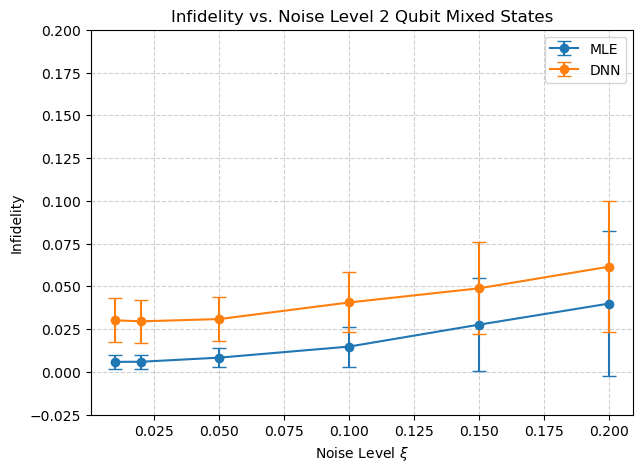

In [74]:
xi = [0.01, 0.02, 0.05, 0.1, 0.15, 0.2]
fidelities = np.array([MLE_fid_01_mixed_state, MLE_fid_02_mixed_state, MLE_fid_05_mixed_state, MLE_fid_10_mixed_state, MLE_fid_15_mixed_state, MLE_fid_20_mixed_state])
std = np.array([MLE_std_01_mixed_state, MLE_std_02_mixed_state, MLE_std_05_mixed_state, MLE_std_10_mixed_state, MLE_std_15_mixed_state, MLE_std_20_mixed_state])
#NN fidelities
fidelities_NN = np.array([NN_01_fid_mixed_state, NN_02_fid_mixed_state, NN_05_fid_mixed_state, NN_10_fid_mixed_state, NN_15_fid_mixed_state, NN_20_fid_mixed_state])
std_NN =  np.array([NN_std_01_mixed_state, NN_std_02_mixed_state, NN_std_05_mixed_state, NN_std_10_mixed_state, NN_std_15_mixed_state, NN_std_20_mixed_state])

plt.figure(figsize=(7,5))
plt.errorbar(xi, 1-fidelities, yerr=std, fmt='o-', capsize=5, label="MLE", markersize=6)
plt.errorbar(xi, 1-fidelities_NN, yerr=std_NN, fmt='o-', capsize=5, label="DNN", markersize=6)

plt.xlabel(r"Noise Level $\xi$")
plt.ylabel("Infidelity")
plt.title("Infidelity vs. Noise Level 2 Qubit Mixed States")
plt.ylim(-0.025,0.2)
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.show()

# Basis Level Noise

In [62]:
data_01_b = np.load('../datasets/2q_basis_noise/2q_noise_0.01.npz', allow_pickle=True)
data_02_b = np.load('../datasets/2q_basis_noise/2q_noise_0.02.npz', allow_pickle=True)
data_05_b = np.load('../datasets/2q_basis_noise/2q_noise_0.05.npz', allow_pickle=True)
data_10_b = np.load('../datasets/2q_basis_noise/2q_noise_0.10.npz', allow_pickle=True)
data_15_b = np.load('../datasets/2q_basis_noise/2q_noise_0.15.npz', allow_pickle=True)
data_20_b = np.load('../datasets/2q_basis_noise/2q_noise_0.20.npz', allow_pickle=True)


X_01_b = data_01_b['counts'] / data_01_b['shots_per_basis']; y_01_b = data_01_b['states']
X_02_b = data_02_b['counts'] / data_02_b['shots_per_basis']; y_02_b = data_02_b['states']
X_05_b = data_05_b['counts'] / data_05_b['shots_per_basis']; y_05_b = data_05_b['states']
X_10_b = data_10_b['counts'] / data_10_b['shots_per_basis']; y_10_b = data_10_b['states']
X_15_b = data_15_b['counts'] / data_15_b['shots_per_basis']; y_15_b = data_15_b['states']
X_20_b = data_20_b['counts'] / data_20_b['shots_per_basis']; y_20_b = data_20_b['states']


rng = np.random.default_rng(42)
test_ind_pure = rng.choice(50_000, size=1000, replace=False)
test_ind_mixed = rng.integers(50_000, 100_000, size=1000)

## Pure States

In [63]:
MLE_fid_01_pure_b, MLE_std_01_pure_b = MLE_Avg_fidelity(data_01_b, X_01_b[test_ind_pure], y_01_b[test_ind_pure])
MLE_fid_02_pure_b, MLE_std_02_pure_b = MLE_Avg_fidelity(data_02_b, X_02_b[test_ind_pure], y_02_b[test_ind_pure])
MLE_fid_05_pure_b, MLE_std_05_pure_b = MLE_Avg_fidelity(data_05_b, X_05_b[test_ind_pure], y_05_b[test_ind_pure])
MLE_fid_10_pure_b, MLE_std_10_pure_b = MLE_Avg_fidelity(data_10_b, X_10_b[test_ind_pure], y_10_b[test_ind_pure])
MLE_fid_15_pure_b, MLE_std_15_pure_b = MLE_Avg_fidelity(data_15_b, X_15_b[test_ind_pure], y_15_b[test_ind_pure])
MLE_fid_20_pure_b, MLE_std_20_pure_b = MLE_Avg_fidelity(data_20_b, X_20_b[test_ind_pure], y_20_b[test_ind_pure])

In [64]:
NN_fid_01_pure_b, NN_std_01_pure_b = train_NN_fidelity(X_01_b, y_01_b, test_ind_pure)
NN_fid_02_pure_b, NN_std_02_pure_b = train_NN_fidelity(X_02_b, y_02_b, test_ind_pure)
NN_fid_05_pure_b, NN_std_05_pure_b = train_NN_fidelity(X_05_b, y_05_b, test_ind_pure)
NN_fid_10_pure_b, NN_std_10_pure_b = train_NN_fidelity(X_10_b, y_10_b, test_ind_pure)
NN_fid_15_pure_b, NN_std_15_pure_b = train_NN_fidelity(X_15_b, y_15_b, test_ind_pure)
NN_fid_20_pure_b, NN_std_20_pure_b = train_NN_fidelity(X_20_b, y_20_b, test_ind_pure)

Epoch 1/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.1171 - val_loss: 0.0087
Epoch 2/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0132 - val_loss: 0.0071
Epoch 3/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0111 - val_loss: 0.0063
Epoch 4/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0101 - val_loss: 0.0066
Epoch 5/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0094 - val_loss: 0.0058
Epoch 6/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0092 - val_loss: 0.0054
Epoch 7/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0089 - val_loss: 0.0053
Epoch 8/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0085 - val_loss: 0.0054
Epoch 9/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0083 - val_loss: 0.0049
Epoch 10/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0082 - val_loss: 0.0050
Epoch 11/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0080 - val_loss: 0.0051
Epoch 12/20
1393/1393 ━━━━━━━━

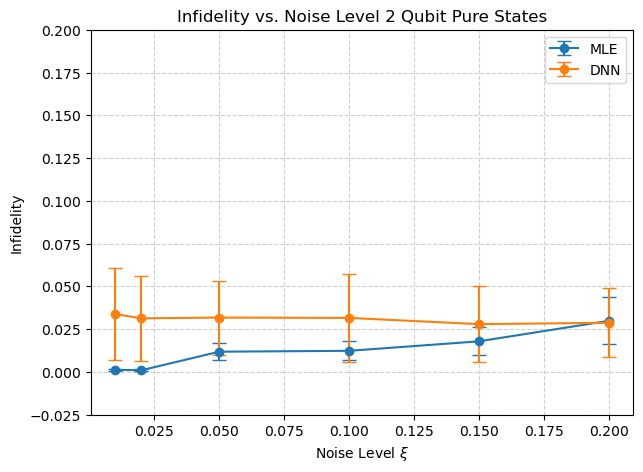

In [79]:
xi = [0.01, 0.02, 0.05, 0.1, 0.15, 0.20]
mle_fidelities = np.array([MLE_fid_01_pure_b, MLE_fid_02_pure_b, MLE_fid_05_pure_b, MLE_fid_10_pure_b, MLE_fid_15_pure_b, MLE_fid_20_pure_b])
std = np.array([MLE_std_01_pure_b, MLE_std_02_pure_b, MLE_std_05_pure_b, MLE_std_10_pure_b, MLE_std_15_pure_b, MLE_std_20_pure_b])
#NN fidelities
fidelities_NN = np.array([NN_fid_01_pure_b, NN_fid_02_pure_b, NN_fid_05_pure_b, NN_fid_10_pure_b, NN_fid_15_pure_b, NN_fid_20_pure_b])
std_NN =  np.array([NN_std_01_pure_b, NN_std_02_pure_b, NN_std_05_pure_b, NN_std_10_pure_b, NN_std_15_pure_b, NN_std_20_pure_b])

plt.figure(figsize=(7,5))
plt.errorbar(xi, 1-mle_fidelities, yerr=std, fmt='o-', capsize=5, label="MLE", markersize=6)
plt.errorbar(xi, 1-fidelities_NN, yerr=std_NN, fmt='o-', capsize=5, label="DNN", markersize=6)

plt.xlabel(r"Noise Level $\xi$")
plt.ylabel("Infidelity")
plt.title("Infidelity vs. Noise Level 2 Qubit Pure States")
plt.ylim(-0.025,0.2)
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.show()

## Mixed States

In [70]:
MLE_fid_01_mixed_b, MLE_std_01_mixed_b = MLE_Avg_fidelity(data_01_b, X_01_b[test_ind_mixed], y_01_b[test_ind_mixed])
MLE_fid_02_mixed_b, MLE_std_02_mixed_b = MLE_Avg_fidelity(data_02_b, X_02_b[test_ind_mixed], y_02_b[test_ind_mixed])
MLE_fid_05_mixed_b, MLE_std_05_mixed_b = MLE_Avg_fidelity(data_05_b, X_05_b[test_ind_mixed], y_05_b[test_ind_mixed])
MLE_fid_10_mixed_b, MLE_std_10_mixed_b = MLE_Avg_fidelity(data_10_b, X_10_b[test_ind_mixed], y_10_b[test_ind_mixed])
MLE_fid_15_mixed_b, MLE_std_15_mixed_b = MLE_Avg_fidelity(data_15_b, X_15_b[test_ind_mixed], y_15_b[test_ind_mixed])
MLE_fid_20_mixed_b, MLE_std_20_mixed_b = MLE_Avg_fidelity(data_20_b, X_20_b[test_ind_mixed], y_20_b[test_ind_mixed])

In [71]:
NN_fid_01_mixed_b, NN_std_01_mixed_b = train_NN_fidelity(X_01_b, y_01_b, test_ind_mixed)
NN_fid_02_mixed_b, NN_std_02_mixed_b = train_NN_fidelity(X_02_b, y_02_b, test_ind_mixed)
NN_fid_05_mixed_b, NN_std_05_mixed_b = train_NN_fidelity(X_05_b, y_05_b, test_ind_mixed)
NN_fid_10_mixed_b, NN_std_10_mixed_b = train_NN_fidelity(X_10_b, y_10_b, test_ind_mixed)
NN_fid_15_mixed_b, NN_std_15_mixed_b = train_NN_fidelity(X_15_b, y_15_b, test_ind_mixed)
NN_fid_20_mixed_b, NN_std_20_mixed_b = train_NN_fidelity(X_20_b, y_20_b, test_ind_mixed)

Epoch 1/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1159 - val_loss: 0.0082
Epoch 2/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0133 - val_loss: 0.0063
Epoch 3/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0111 - val_loss: 0.0068
Epoch 4/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0100 - val_loss: 0.0059
Epoch 5/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0094 - val_loss: 0.0054
Epoch 6/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0091 - val_loss: 0.0059
Epoch 7/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0087 - val_loss: 0.0053
Epoch 8/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0085 - val_loss: 0.0051
Epoch 9/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0081 - val_loss: 0.0059
Epoch 10/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0081 - val_loss: 0.0051
Epoch 11/20
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0078 - val_loss: 0.0048
Epoch 12/20
1393/1393 ━━━━━━━━

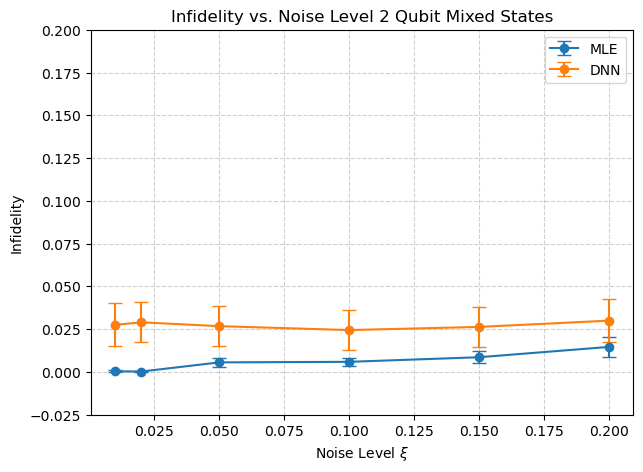

In [76]:
xi = [0.01, 0.02, 0.05, 0.1, 0.15, 0.20]
mle_fidelities = np.array([MLE_fid_01_mixed_b, MLE_fid_02_mixed_b, MLE_fid_05_mixed_b, MLE_fid_10_mixed_b, MLE_fid_15_mixed_b, MLE_fid_20_mixed_b])
std = np.array([MLE_std_01_mixed_b, MLE_std_02_mixed_b, MLE_std_05_mixed_b, MLE_std_10_mixed_b, MLE_std_15_mixed_b, MLE_std_20_mixed_b])
#NN fidelities
fidelities_NN = np.array([NN_fid_01_mixed_b, NN_fid_02_mixed_b, NN_fid_05_mixed_b, NN_fid_10_mixed_b, NN_fid_15_mixed_b, NN_fid_20_mixed_b])
std_NN =  np.array([NN_std_01_mixed_b, NN_std_02_mixed_b, NN_std_05_mixed_b, NN_std_10_mixed_b, NN_std_15_mixed_b, NN_std_20_mixed_b])

plt.figure(figsize=(7,5))
plt.errorbar(xi, 1-mle_fidelities, yerr=std, fmt='o-', capsize=5, label="MLE", markersize=6)
plt.errorbar(xi, 1-fidelities_NN, yerr=std_NN, fmt='o-', capsize=5, label="DNN", markersize=6)

plt.xlabel(r"Noise Level $\xi$")
plt.ylabel("Infidelity")
plt.title("Infidelity vs. Noise Level 2 Qubit Mixed States")
plt.ylim(-0.025,0.2)
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.show()